In [1]:
%env RAYON_NUM_THREADS=12
%env RUST_BACKTRACE=1

env: RAYON_NUM_THREADS=12
env: RUST_BACKTRACE=1


In [2]:
import aesara
import aesara.tensor as at
import pymc as pm
import numpy as np
import nuts_py
import numba
from math import prod
import fastprogress
import arviz
import pandas as pd
import threadpoolctl
import nuts_py.convert
from scipy import optimize, stats
import matplotlib.pyplot as plt
import seaborn as sns

/home/adr/miniconda3/envs/pymc4-dev/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: dev is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(np.float64)
county_idx, counties = pd.factorize(data.county)
coords = {"county": counties, "obs_id": np.arange(len(county_idx))}

In [4]:
with pm.Model(coords=coords, check_bounds=False) as model:
    # Intercepts, non-centered
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
    sigma_a = pm.HalfNormal("sigma_a", 1.0)
    a = pm.Normal("a", dims="county") * sigma_a + mu_a

    # Slopes, non-centered
    
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=2.)
    sigma_b = pm.HalfNormal("sigma_b", 1.0)
    b = pm.Normal("b", dims="county") * sigma_b + mu_b

    eps = pm.HalfNormal("eps", 1.5)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    #radon_est = a[0] + b[0] * data.floor.values

    radon_like = pm.Normal(
        "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon.values,
        dims="obs_id"
    )

In [5]:
n_chains = 10

In [6]:
%%time
with threadpoolctl.threadpool_limits(1):
    with model:
        trace_py = pm.sample(
            init="jitter+adapt_diag_grad",
            draws=1000,
            chains=n_chains,
            cores=10,
            idata_kwargs={"log_likelihood": False},
            compute_convergence_checks=False,
            target_accept=0.8,
            #max_treedepth=10,
            discard_tuned_samples=False,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [mu_a, sigma_a, a, mu_b, sigma_b, b, eps]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 13 seconds.


CPU times: user 13.7 s, sys: 968 ms, total: 14.7 s
Wall time: 23.3 s


In [7]:
%%time
with threadpoolctl.threadpool_limits(1):
    with model:
        trace_py2 = pm.sample(
            init="jitter+adapt_diag",
            draws=1000,
            chains=n_chains,
            cores=10,
            idata_kwargs={"log_likelihood": False},
            compute_convergence_checks=False,
            target_accept=0.8,
            #max_treedepth=10,
            discard_tuned_samples=False,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [mu_a, sigma_a, a, mu_b, sigma_b, b, eps]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6952, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5889, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6951, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 14.2 s, sys: 778 ms, total: 15 s
Wall time: 21.5 s


In [8]:
from aesara import config

In [9]:
config.numba__error_model = "numpy"
config.numba__nogil = True
config.numba__cache = False
config.numba__boundscheck = True
config.numba__fastmath = True
config.numba__parallel = False

In [10]:
kwargs = {
    "error_model": config.numba__error_model,
    "nogil": config.numba__nogil,
    "boundscheck": config.numba__boundscheck,
    "fastmath": config.numba__fastmath,
    "parallel": config.numba__parallel,
}

In [11]:
import aeppl
from aeppl.logprob import CheckParameterValue
import aesara.link.numba.dispatch

@aesara.link.numba.dispatch.numba_funcify.register(CheckParameterValue)
def numba_functify_CheckParameterValue(op, **kwargs):
    @aesara.link.numba.dispatch.basic.numba_njit
    def check(value, *conditions):
        return value
    
    return check

@aesara.link.numba.dispatch.numba_funcify.register(aesara.tensor.subtensor.AdvancedIncSubtensor1)
def numba_funcify_IncSubtensor(op, node, **kwargs):

    def incsubtensor_fn(z, vals, idxs):
        z = z.copy()
        for idx, val in zip(idxs, vals):
            z[idx] += val
        return z

    return aesara.link.numba.dispatch.basic.numba_njit(incsubtensor_fn)

In [12]:
%%time
n_dim, logp_func, expanding_function, shape_info = nuts_py.convert.make_functions(model)
logp_func = numba.njit(**kwargs)(logp_func)
logp_numba_raw, c_sig = nuts_py.convert.make_c_logp_func(n_dim, logp_func)
logp_numba = numba.cfunc(c_sig, **kwargs)(logp_numba_raw)

CPU times: user 16.7 s, sys: 193 ms, total: 16.8 s
Wall time: 16.9 s


In [13]:
x = np.random.randn(n_dim)

In [14]:
#from numba.pycc import CC

#cc = CC('logp_module')
#cc.target_cpu = "host"
#logp_func(np.random.randn(n_dim))
#cc.export("logp_grad", logp_func.signatures[0])(logp_func)
#cc.compile()

#import logp_module
#%timeit logp_module.logp_grad(x)

In [15]:
optimize.check_grad(lambda x: logp_func(x)[0], lambda x: logp_func(x)[1], x)

0.0005406516057780196

In [16]:
n_draws = 1000
seed = 40

In [17]:
def make_user_data():
    return 0

settings = nuts_py.lib.PySamplerArgs()
settings.num_tune = 1000
settings.maxdepth = 10
settings.target_accept = 0.8
settings.save_mass_matrix = True

x = np.random.default_rng(42).normal(size=n_dim)

In [18]:
%%time
draws = []
tune = []
stats = []
for i in range(1):
    sampler = nuts_py.lib.PySampler(logp_numba.address, make_user_data, x, n_dim, settings, draws=n_draws + settings.num_tune, chain=0, seed=seed + i)
    for (draw, stat) in sampler:
        draws.append(draw)
        stats.append(stat)

CPU times: user 484 ms, sys: 1e+03 ns, total: 484 ms
Wall time: 483 ms


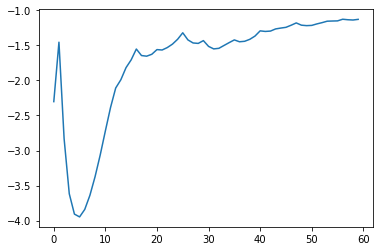

In [19]:
plt.plot(np.log([stat.as_dict()["step_size_bar"] for stat in stats])[:60])

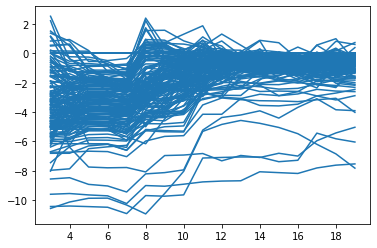

In [20]:
mass_matrix = np.array([stat.as_dict()["current_mass_matrix_inv_diag"] for stat in stats])[:50, :]
plt.plot(np.log(mass_matrix)[:20], color="C0");

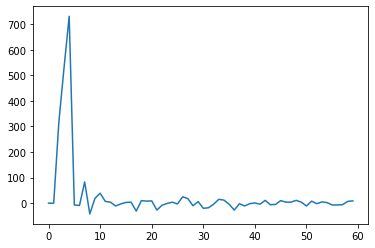

In [21]:
plt.plot(([stat.as_dict()["index_in_trajectory"] for stat in stats])[:60])

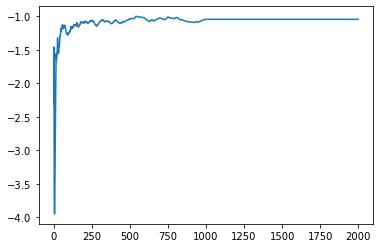

In [22]:
plt.plot([np.log(stat.as_dict()["step_size_bar"]) for stat in stats])

In [23]:
n_chains = 10

In [38]:
%%time
for _ in range(1):
    with threadpoolctl.threadpool_limits(1):
        trace_rust = nuts_py.convert.sample(
            model,
            N=n_dim,
            logp_numba=logp_numba,
            expanding_function=expanding_function,
            shape_info=shape_info,
            max_treedepth=10,
            n_tune=1000,
            n_draws=1000,
            n_chains=n_chains,
            seed=8,
            target_accept=0.8,
            discard_window=0
        )

CPU times: user 5.51 s, sys: 82.2 ms, total: 5.6 s
Wall time: 822 ms


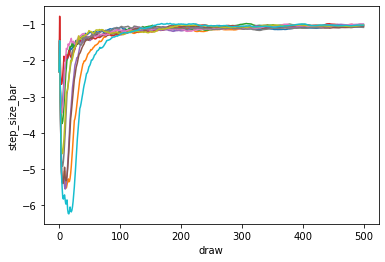

In [39]:
np.log(trace_rust.warmup_sample_stats.step_size_bar.isel(draw=slice(0, 500))).plot(x="draw", hue="chain", add_legend=False);

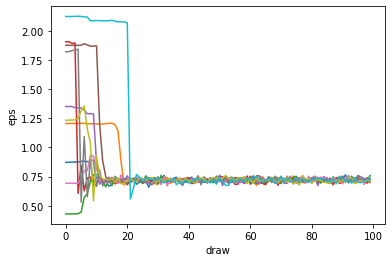

In [40]:
trace_rust.warmup_posterior.eps.isel(draw=slice(0, 100)).plot(x="draw", hue="chain", add_legend=False);

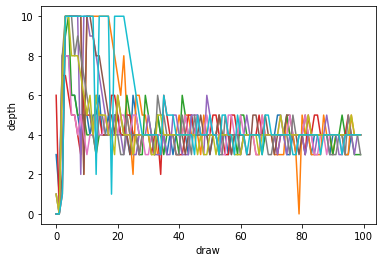

In [41]:
trace_rust.warmup_sample_stats.depth.isel(draw=slice(0, 100)).plot(x="draw", hue="chain", add_legend=False);

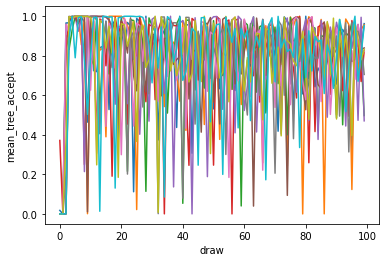

In [42]:
trace_rust.warmup_sample_stats.mean_tree_accept.isel(draw=slice(None, 100)).plot(x="draw", hue="chain", add_legend=False);

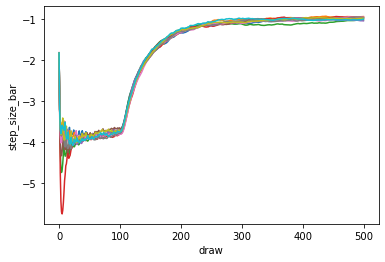

In [43]:
np.log(trace_py.warmup_sample_stats.step_size_bar).isel(draw=slice(None, 500)).plot(x="draw", hue="chain", add_legend=False);

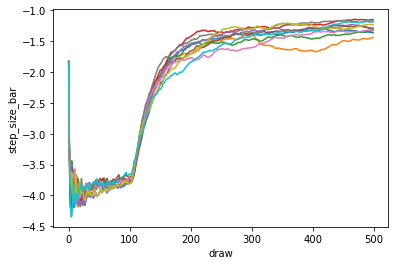

In [44]:
np.log(trace_py2.warmup_sample_stats.step_size_bar).isel(draw=slice(None, 500)).plot(x="draw", hue="chain", add_legend=False);

In [45]:
ess_py = arviz.ess(trace_py)
ess_py2 = arviz.ess(trace_py2)
ess_rust = arviz.ess(trace_rust)

In [46]:
(2 ** trace_py.warmup_sample_stats.tree_depth).sum()

<xarray.DataArray 'tree_depth' ()>
array(296684)

In [47]:
(2 ** trace_py2.warmup_sample_stats.tree_depth).sum()

<xarray.DataArray 'tree_depth' ()>
array(335784)

In [48]:
(2 ** trace_rust.warmup_sample_stats.depth).sum()

<xarray.DataArray 'depth' ()>
array(208475)

In [49]:
ess_rust.min()

<xarray.Dataset>
Dimensions:        ()
Data variables:
    mu_a           float64 5.595e+03
    sigma_a_log__  float64 3.77e+03
    a              float64 5.078e+03
    mu_b           float64 1.256e+04
    sigma_b_log__  float64 1.789e+03
    b              float64 7.506e+03
    eps_log__      float64 1.025e+04
    sigma_a        float64 3.77e+03
    sigma_b        float64 1.789e+03
    eps            float64 1.025e+04

In [50]:
ess_py.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu_a     float64 5.67e+03
    a        float64 5.85e+03
    mu_b     float64 1.103e+04
    b        float64 7.511e+03
    sigma_a  float64 3.996e+03
    sigma_b  float64 1.914e+03
    eps      float64 1.176e+04

In [51]:
ess_py2.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu_a     float64 3.4e+03
    a        float64 3.93e+03
    mu_b     float64 5.253e+03
    b        float64 5.972e+03
    sigma_a  float64 3.157e+03
    sigma_b  float64 1.372e+03
    eps      float64 6.328e+03